In [1]:
from sqlalchemy import create_engine

In [2]:
import pandas as pd

In [53]:
server = 'UTILISATEUR-PC'
database = 'Chidiebere'
driver = 'ODBC Driver 17 for SQL Server'
username = r'Utilisateur-PC\Utilisateur'  
password = ''

In [54]:
connection_string = (
    "mssql+pyodbc://UTILISATEUR-PC/Chidiebere?"
    "driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)

In [55]:
engine = create_engine(connection_string)

In [56]:
query= "select * from Diet"

In [57]:
df = pd.read_sql(query, engine)

In [58]:
data= pd.read_sql(query,engine)

In [59]:
df.head(5)

,Person,gender,Age,Height,pre_weight,Diet,weight6weeks
0,25,None,41,171,60,2,60.000000
1,26,None,32,174,103,2,103.000000
2,1,False,22,159,58,1,54.200001
3,2,False,46,192,60,1,54.000000
4,3,False,55,170,64,1,63.299999


In [60]:
# Checking for significant outliers.

import numpy as np
from scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
def detect_outliers_zscore(data, group_col, value_col, threshold=3):
    outlier_flags = pd.Series(False, index=data.index)
    for group, group_data in data.groupby(group_col):
        z_scores = np.abs(zscore(group_data[value_col]))
        outlier_flags.loc[group_data.index] = z_scores > threshold
    return outlier_flags

In [62]:
zscore_outliers = detect_outliers_zscore(df, 'Diet', 'weight6weeks')

In [63]:
outliers_df = df[zscore_outliers]
print("Z-Score Outliers Detected:")
print(outliers_df)

Z-Score Outliers Detected:
   Person gender  Age  Height  pre_weight  Diet  weight6weeks
1      26   None   32     174         103     2         103.0


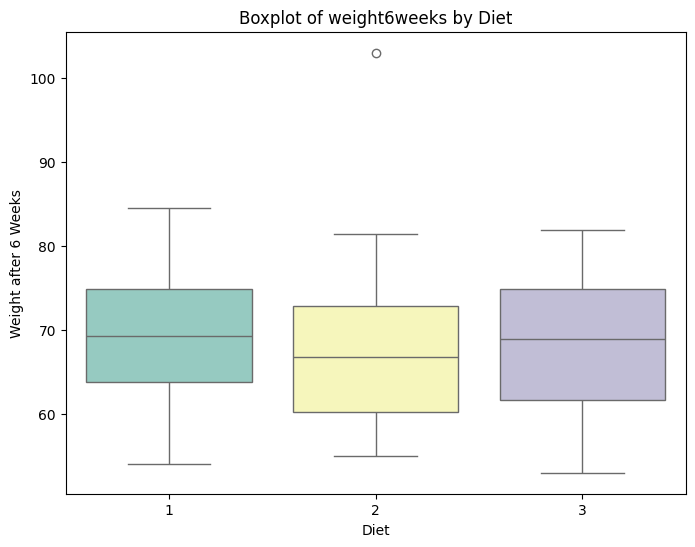

In [64]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Diet', y='weight6weeks', data=df, hue='Diet', palette='Set3', legend=False)
plt.title("Boxplot of weight6weeks by Diet")
plt.xlabel("Diet")
plt.ylabel("Weight after 6 Weeks")
plt.legend([], [], frameon=False)  
plt.show()

In [65]:
# Checking if the dependent variable(weight6weeks) is normally distributed.

from scipy.stats import shapiro

In [66]:
stat, p_value = shapiro(df['weight6weeks'].dropna())

In [67]:
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")

Shapiro-Wilk Test Statistic: 0.9579501486717568
P-value: 0.011489306771877953


In [68]:
# Since the dependent variable (weight6weeks) was not normally distributed, a Box-Cox transformation was applied.

from scipy.stats import boxcox

In [69]:
df = df.copy()
if (df['weight6weeks'] <= 0).any():
    raise ValueError("Box-Cox transformation requires strictly positive values.")

In [70]:
transformed_values, fitted_lambda = boxcox(df['weight6weeks'])

In [71]:
df['weight6weeks_boxcox'] = transformed_values

In [72]:
print(df.columns)

Index(['Person', 'gender', 'Age', 'Height', 'pre_weight', 'Diet',
       'weight6weeks', 'weight6weeks_boxcox'],
      dtype='object')


In [73]:
stat, p = shapiro(df['weight6weeks_boxcox'])
print(f"Shapiro-Wilk test on Box-Cox transformed data:")
print(f"  W = {stat:.4f}, p = {p:.4f}")

Shapiro-Wilk test on Box-Cox transformed data:
  W = 0.9805, p = 0.2749


In [74]:
# Since the dependent variable (weight6weeks) has been transformed into weight6weeks_boxcox and now follows a normal distribution, we can proceed to assess the normality within each group of the independent variable (Diet).

def shapiro_grouped(df, value_col='weight6weeks_boxcox', group_col='Diet'):
    print(f"Shapiro-Wilk Normality Test for each group in '{group_col}' on '{value_col}'\n")
    results = []

    for group, subset in df.groupby(group_col):
        data = subset[value_col].dropna()
        stat, p = shapiro(data)
        normal = 'Yes' if p > 0.05 else 'No'
        print(f"Diet {group}:")
        print(f"  Sample size: {len(data)}")
        print(f"  W statistic: {stat:.4f}")
        print(f"  p-value:     {p:.4f}")
        print(f"  Normal?      {normal} (at α = 0.05)\n")
        results.append({'Diet': group, 'W statistic': stat, 'p-value': p, 'Normal?': normal})

    return pd.DataFrame(results).set_index('Diet')

In [75]:
normality_results = shapiro_grouped(df)

Shapiro-Wilk Normality Test for each group in 'Diet' on 'weight6weeks_boxcox'

Diet 1:
  Sample size: 24
  W statistic: 0.9572
  p-value:     0.3845
  Normal?      Yes (at α = 0.05)

Diet 2:
  Sample size: 27
  W statistic: 0.9460
  p-value:     0.1709
  Normal?      Yes (at α = 0.05)

Diet 3:
  Sample size: 27
  W statistic: 0.9548
  p-value:     0.2789
  Normal?      Yes (at α = 0.05)



In [76]:
# Checking for Homogeneity of variance (Levene's test > 0.05)

from scipy.stats import levene

In [77]:
group1 = df[df['Diet'] == 1]['weight6weeks_boxcox'].dropna()
group2 = df[df['Diet'] == 2]['weight6weeks_boxcox'].dropna()
group3 = df[df['Diet'] == 3]['weight6weeks_boxcox'].dropna()

In [78]:
stat, p = levene(group1, group2, group3)

In [79]:
print("Levene’s Test for Homogeneity of Variances:")
print(f"  Test Statistic = {stat:.4f}")
print(f"  p-value        = {p:.4f}")

Levene’s Test for Homogeneity of Variances:
  Test Statistic = 0.4523
  p-value        = 0.6379


In [80]:
# After verifying all necessary assumptions, we will proceed with the one-way ANOVA.

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

In [81]:
df['Diet'] = df['Diet'].astype('category')

In [82]:
model = smf.ols('weight6weeks_boxcox ~ C(Diet)', data=df).fit()

In [83]:
anova_table = sm.stats.anova_lm(model, typ=2)
print("One-Way ANOVA Table:")
print(anova_table)

One-Way ANOVA Table:
            sum_sq    df         F    PR(>F)
C(Diet)   0.000041   2.0  0.260092  0.771673
Residual  0.005950  75.0       NaN       NaN
